# Entrega 2

## Librerias

In [85]:
# Librerias
!pip install rasterio
!pip install seaborn
!pip install scikit-image

In [1]:
from sklearn.preprocessing import MinMaxScaler
from typing import List
from matplotlib import colors
from skimage import exposure

import rasterio as rio
import rasterio.plot as rio_plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import json

# Semilla pseudoaleatoria
np.random.seed(24)

# Tamaño de las figuras
plt.rcParams["figure.figsize"] = (20,10)

# Ruta base de la carpeta de datos
DATA_BASE = "/home/ggonzr_cloud/deeplearn/data"

## Exploración

En este apartado vamos a explorar algunas imagenes del conjunto de datos, los archivos que contiene la etiqueta de la imagen y la máscara.

### Carga de imágenes

A continuación vamos a buscar las rutas de acceso a las imagenes. Dado a que el conjunto de etiquetas es más pequeño que las imagenes, vamos a emplear un conjunto reducido tal que tengamos etiquetas para todas la imagenes a emplear

In [2]:
# Directorios de las etiquetas y la imagenes
LABEL_DIR = f"{DATA_BASE}/ref_landcovernet_v1_labels"
IMAGE_DIR = f"{DATA_BASE}/ref_source_sample"

In [3]:
# Listar los subdirectorios de cada carpeta: Etiquetas
label_dirs = glob.glob(f"{LABEL_DIR}/*")
print(f"Número de etiquetas disponibles: {len(label_dirs)}")

Número de etiquetas disponibles: 1982


In [4]:
# Listar los subdirectorios de cada carpeta: Etiquetas
image_dirs = glob.glob(f"{IMAGE_DIR}/*")
print(f"Número de etiquetas disponibles: {len(image_dirs)}")

Número de etiquetas disponibles: 13557


In [5]:
label_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_36PZC_07'

In [6]:
image_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_source_sample/ref_landcovernet_v1_source_36RVP_14_20181217'

A continuación vamos a seleccionar solo el subconjunto de las imagenes con etiqueta

In [7]:
def filter_path(path_f: str, label_dirs: List[str]) -> bool:
    """
    Nos permite filtar la ruta de la imagen para determinar
    si esta tiene una máscara asociada.
    """
    try:
        # Filtro para la carpeta de interés
        name = path_f.split("/")[-1]        

        # Filtro para la etiqueta de la imagen
        # El patrón parece ser el siguiente
        # Nombre_source_<Sensor>_<ID>_<Fecha de toma>
        split_tags = name.split("_")
        img_id = f"{split_tags[-3]}_{split_tags[-2]}"       

        # Colocar el patrón como se nombran las imágenes
        label_tag = f"{LABEL_DIR}/ref_landcovernet_v1_labels_{img_id}"
        #print(f"Image ID: {img_id}")
        #print(f"Label tag: {label_tag}")

        # Validar si existe
        return label_tag in label_dirs
    except:
        return False

In [8]:
# Filtrar
image_dirs_2 = [
    tag
    for tag in image_dirs
    if filter_path(path_f=tag, label_dirs=label_dirs)
]

In [9]:
print(f"Imagenes con etiqueta: {len(image_dirs_2)}")

Imagenes con etiqueta: 13557


Como podemos observar, tenemos todas las etiquetas para todas las regiones del dataset. Lo anterior implica que el número de X indica los cultivos disponibles para realizar el análisis. Para mayor facilidad de acceso, vamos a agrupar todas las regiones en una vista que nos permita acceder rápidamente tanto a las imágenes disponibles de la región como a su máscara

In [10]:
# Diccionario para almacenar los datos
# La llave será el ID de la región y su valor serán dos listas:
# La primera con la ruta de las imagenes
# La segunda con la máscara (espero solo sea una)
regions_img_labels = {}

Generar la vista para las máscaras

In [11]:
for label_mask in label_dirs:
    mask_name = label_mask.split("/")[-1]
    mask_split = mask_name.split("_")
    
    try:
        mask_id = f"{mask_split[-2]}_{mask_split[-1]}"
    except:
        continue    
    
    if mask_id not in regions_img_labels:
        # Nueva entrada
        entry_data = {
            "images": [],
            "masks": [label_mask]
        }
        
        # Agregar la entrada al diccionario principal
        regions_img_labels[mask_id] = entry_data
    else:
        # Consultar el diccionario y agregar la otra máscara
        regions_img_labels[mask_id]["masks"].append(label_mask)       

In [12]:
print(f"Chips disponibles: {len(regions_img_labels.keys())}")

Chips disponibles: 1981


Generar la vista para las imagenes

In [13]:
for image_path in image_dirs:
    try:        
        # Filtrar el nombre y el ID de la imágen
        image_name = image_path.split("/")[-1]
        mask_split = image_name.split("_")
        image_id = f"{mask_split[-3]}_{mask_split[-2]}"        

        # Agregar en la lista
        regions_img_labels[image_id]["images"].append(image_path)
    except:
        continue

Vamos a guardar esta vista, para realizar una carga rápida si se requiere

In [14]:
with open(f"{DATA_BASE}/image_view.json", "w", encoding="utf-8") as v_f:
    json.dump(regions_img_labels, v_f, ensure_ascii=False, indent=4)

## Visualización

Ya con la vista lista, vamos a seleccionar de manera aleatoria una imagen para mostrar

In [15]:
view_keys = list(regions_img_labels.keys())
random_idx = np.random.randint(0, len(view_keys))
random_key = view_keys[random_idx]
print(f"Región seleccionada: {random_key}")

Región seleccionada: 37NFD_10


Seguidamente vamos a seleccionar la máscara y una de las imágenes

In [16]:
ex_mask_folder = regions_img_labels[random_key]["masks"][0]
ex_mask = glob.glob(f"{ex_mask_folder}/labels.*")[0]

In [17]:
ex_img_folder = regions_img_labels[random_key]["images"][0]

Para el conjunto de datos de cobertura de terreno en África, cada una de las carpetas de las imagenes de terreno posee un archivo TIFF para cada banda respectiva. En esta ocasión vamos a seleccionar las bandas Rojo, Verde y Azul para realizar una composición en RGB.

In [18]:
# Bandas RGB de la imagen de ejemplo
ex_img_red = glob.glob(f"{ex_img_folder}/B04.*")[0]
ex_img_green = glob.glob(f"{ex_img_folder}/B03.*")[0]
ex_img_blue = glob.glob(f"{ex_img_folder}/B02.*")[0]

Con ello en mente tenemos las siguientes rutas

In [19]:
print(f"Banda roja de la imagen de ejemplo")
print(ex_img_red)

Banda roja de la imagen de ejemplo
/home/ggonzr_cloud/deeplearn/data/ref_source_sample/ref_landcovernet_v1_source_37NFD_10_20180824/B04.tif


In [20]:
print(f"Máscara semantica")
print(ex_mask)

Máscara semantica
/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_37NFD_10/labels.tif


### Cargar y visualizar

#### Máscara

In [21]:
ex_mask_rio = rio.open(ex_mask)

In [22]:
print(f"Metadatos{ex_mask_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32637), 'transform': Affine(10.0, 0.0, 684830.0,
       0.0, -10.0, 342960.0)}


In [23]:
# Primera capa con las etiquetas
ex_labels_mask = ex_mask_rio.read(1)

In [24]:
ex_labels_mask

array([[7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 3, 3, 7],
       [7, 7, 7, ..., 7, 3, 7],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], dtype=uint16)

In [25]:
# Crear un colormap personalizado para cada una de las etiquetas
# según el documento
cmap = colors.ListedColormap([
    "#0000ff",
    "#888888",
    "#d1a46d",
    "#f5f5ff",
    "#d64c2b",
    "#186818",
    "#00ff00"
])
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]
boundaries = list(range(1,8))
norm = colors.BoundaryNorm(boundaries, cmap.N)

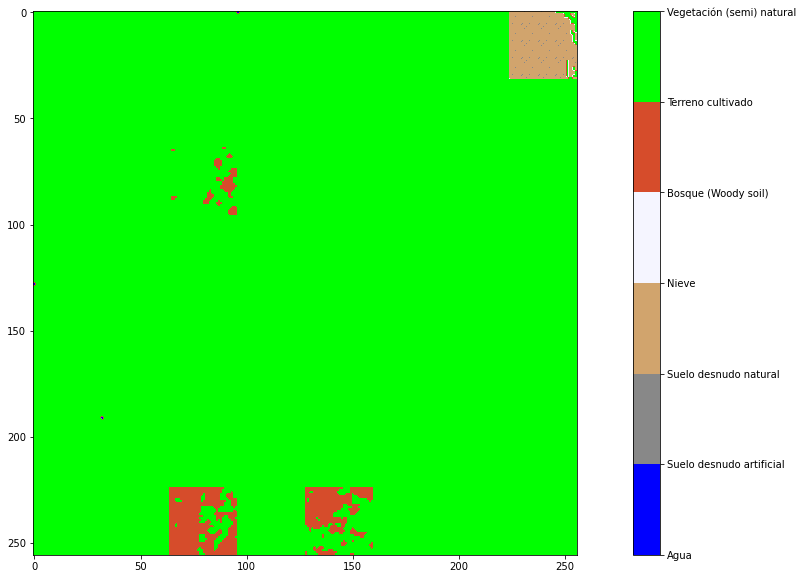

In [26]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

#### Imagen

In [27]:
ex_image_red_rio = rio.open(ex_img_red)
ex_image_green_rio = rio.open(ex_img_green)
ex_image_blue_rio = rio.open(ex_img_blue)

In [28]:
print(f"Metadatos{ex_image_red_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32637), 'transform': Affine(10.0, 0.0, 684830.0,
       0.0, -10.0, 342960.0)}


Como podemos observar, la imagen posee 10 bandas. A continuación, vamos a visualizar la imagen en combinación de color verdadero

In [29]:
ex_image_red_rio_data = ex_image_red_rio.read(1)
ex_image_green_rio_data = ex_image_green_rio.read(1)
ex_image_green_rio_data = ex_image_blue_rio.read(1)

Escalar la imagen

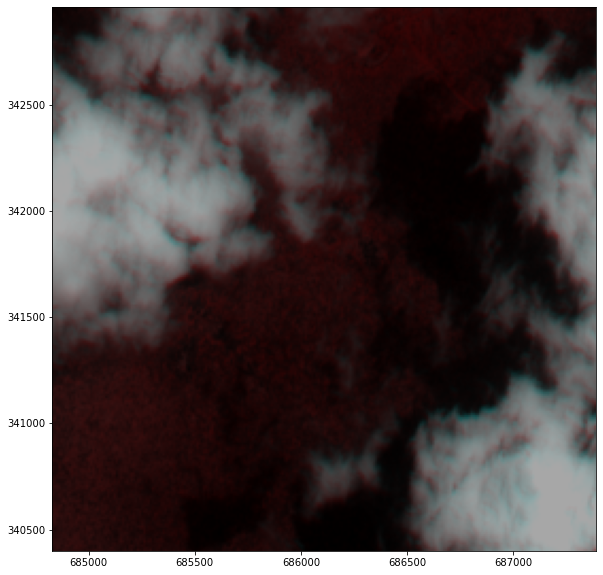

<AxesSubplot:>

In [32]:
# Combinación RGB
ex_image_rgb = np.array([
    ex_image_red_rio_data,
    ex_image_green_rio_data,
    ex_image_green_rio_data
])

# Reescalar los datos de las bandas
mms = MinMaxScaler(feature_range=(0, 255))
ex_c = ex_image_rgb.copy()
p2, p98 = np.percentile(ex_c, (2,98))

image = exposure.rescale_intensity(ex_c, in_range=(p2, p98)) / 100000

#for band in range(ex_c.shape[0]):
#    ex_c[band] = mms.fit_transform(ex_c[band])

# Mostrar
rio_plot.show(image, transform=ex_image_red_rio.transform)

#### Clasificacion de escena

In [33]:
ex_mask = glob.glob(f"{ex_img_folder}/SCL.*")[0]
ex_mask_rio = rio.open(ex_mask)

In [34]:
print(f"Metadatos{ex_mask_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32637), 'transform': Affine(10.0, 0.0, 684830.0,
       0.0, -10.0, 342960.0)}


In [35]:
# Primera capa con las etiquetas
ex_labels_mask = ex_mask_rio.read(1)

In [36]:
ex_labels_mask

array([[7, 7, 7, ..., 5, 5, 5],
       [7, 7, 7, ..., 5, 5, 5],
       [7, 7, 7, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 9, 9, 9],
       [5, 5, 5, ..., 9, 9, 9],
       [5, 5, 5, ..., 9, 9, 9]], dtype=uint8)

In [37]:
# Crear un colormap personalizado para cada una de las etiquetas
# según el documento
cmap = colors.ListedColormap([
    "#0000ff",
    "#888888",
    "#d1a46d",
    "#f5f5ff",
    "#d64c2b",
    "#186818",
    "#00ff00"
])
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]
boundaries = list(range(1,8))
norm = colors.BoundaryNorm(boundaries, cmap.N)

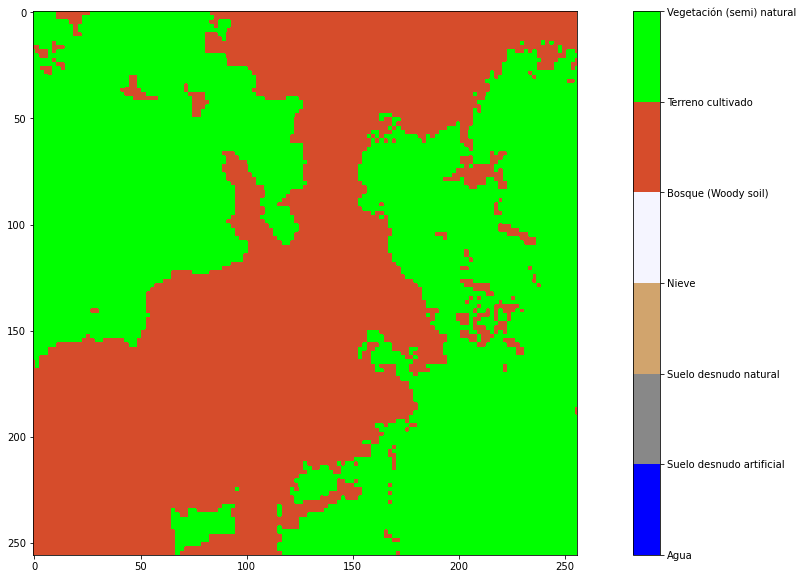

In [38]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

#### Mapa de nubes

In [39]:
ex_img_cloudmask = glob.glob(f"{ex_img_folder}/CLD.*")[0]
ex_cloud_mask = rio.open(ex_img_cloudmask)

In [40]:
print(f"Metadatos de la máscara de nubes: {ex_cloud_mask.meta}")

Metadatos de la máscara de nubes: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32637), 'transform': Affine(10.0, 0.0, 684830.0,
       0.0, -10.0, 342960.0)}


In [41]:
ex_cloud_mask.read(1)

array([[  8,   1,   1, ...,   0,   0,   0],
       [  8,   1,   1, ...,   0,   0,   0],
       [  9,  10,  10, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 100, 100, 100],
       [  0,   0,   0, ..., 100, 100, 100],
       [  0,   0,   0, ..., 100, 100, 100]], dtype=uint8)

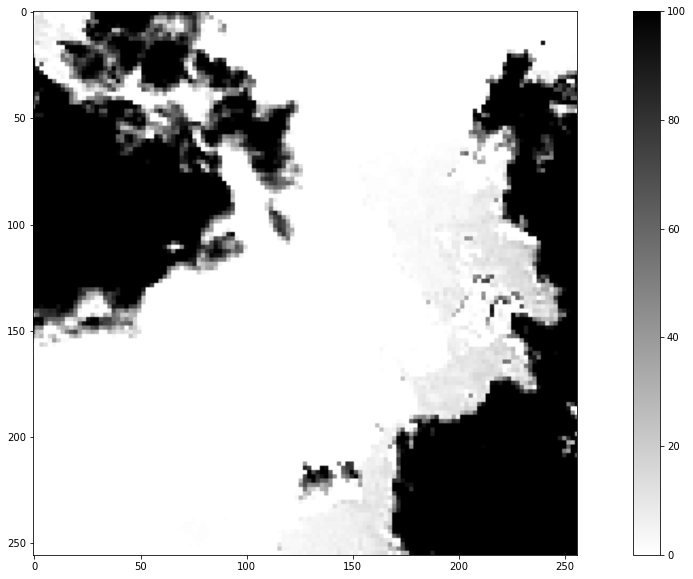

In [42]:
fig, ax = plt.subplots()
img = ax.imshow(ex_cloud_mask.read(1), cmap=plt.get_cmap("gist_yarg"))
fig.colorbar(img, ax=ax)